In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import typing
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data preprocessing

In [4]:
class Chunk:
    def __init__(self, train_part, test_part, feature_names):
        self.train = train_part
        self.test = test_part
        self.features = feature_names
        
    def get_X(self, forvard_time):
        X = list(self.train.P1_filtr_mean.values)
        X += list(self.train.P1_diff1.values)
        X += list(self.train.P1_diff2.values)
        X += list(self.train.P1_diff3.values)
        
        X += list(self.train.temperature_filtr_mean.values)
        X += list(self.train.t_diff.values)
        X += list(self.train.t_diff1.values)
        X += list(self.train.t_diff2.values)
        
        #X += list(self.train.humidity_filtr_mean.values)
        #X += list(self.train.t_diff.values)
        #X += list(self.train.t_diff1.values)
        #X += list(self.train.t_diff2.values)
        
        return X
    
    def get_y(self, forward_time, orig=False):
        if orig:
            return self.test.P1_original.values[forward_time]
        y = self.test.P1_filtr_mean.values[forward_time]
        return y

        
    def get_meta_X(self, forward_time, models):
        X = self.get_X(forward_time)
        model = models[forward_time]
        prediction = model.predict([X])[0]
        X_meta = [prediction]
        for feature in self.features:
            X_meta.append(self.test[feature].values[forward_time])
        return X_meta
        
        

In [5]:
def prepare_data(data):
    data['P1_filtr_mean'] = data.P1_filtr_mean.interpolate()
    
    data['pres_meteo'] = data.pres_meteo.fillna(method='bfill')
    data['temp_meteo'] = data.temp_meteo.fillna(method='bfill')
    data['hum_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['pres_meteo'] = data.pres_meteo.interpolate()
    data['hum_meteo'] = data.hum_meteo.interpolate()
    data['temp_meteo'] = data.temp_meteo.interpolate()
    
    data['humidity_filtr_mean'] = data.humidity_filtr_mean.interpolate()
    data['temperature_filtr_mean'] = data.temperature_filtr_mean.interpolate()
    
    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data['prec_time'] = data.prec_time.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)
    #data['prec_amount'] = data.prec_amount//data.prec_time
    data['prec_time'] = data.prec_time.interpolate()
    data['prec_amount'] = data.prec_amount.interpolate()
    data['wind_direction'] = data.wind_direction.fillna(method='bfill')
    return data

In [6]:
wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
            }

def add_features(data):
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['sin_day'] = np.sin(2*np.pi*data.day_of_week/7)
    data['cos_day'] = np.cos(2*np.pi*data.day_of_week/7)
    data['sin_hour'] = np.sin(2*np.pi*data.hour/24)
    data['cos_hour'] = np.cos(2*np.pi*data.hour/24)
    
    data['P1_diff1'] = data.P1_filtr_mean.diff(periods=1)
    data['P1_diff2'] = data.P1_diff1.diff(periods=1)
    data['P1_diff3'] = data.P1_diff2.diff(periods=1)
    data['t_diff'] = data.temperature_filtr_mean.diff(periods=1)
    data['t_diff1'] = data.t_diff.diff(periods=1)
    data['t_diff2'] = data.t_diff1.diff(periods=1)
    data['h_diff'] = data.humidity_filtr_mean.diff(periods=1)
    data['h_diff1'] = data.h_diff.diff(periods=1)
    data['h_diff2'] = data.h_diff1.diff(periods=1)
    
    data['wind_direction'] = data.wind_direction.map(wind_dir)
    data["wind_sin"] = np.sin(np.radians(data.wind_direction))
    data["wind_cos"] = np.cos(np.radians(data.wind_direction))
    data['wind_sin'] = data.wind_sin.fillna(value=2)
    data['wind_cos'] = data.wind_cos.fillna(value=2)
    
    data['temp_diff'] = data.temp_meteo.diff(periods=3)
    data['humidity_diff'] = data.hum_meteo.diff(periods=3)
    data['pressure_diff'] = data.pres_meteo.diff(periods=3)
    data['wind_sin_diff'] = data.wind_sin.diff(periods=3)
    data['wind_cos_diff'] = data.wind_cos.diff(periods=3)
    data['temp_diff3'] = data.temp_meteo.diff(periods=9)
    data['humidity_diff3'] = data.hum_meteo.diff(periods=9)
    data['pressure_diff3'] = data.pres_meteo.diff(periods=9)
    data['wind_sin_diff3'] = data.wind_sin.diff(periods=9)
    data['wind_cos_diff3'] = data.wind_cos.diff(periods=9)
    return data

In [7]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')

In [8]:
data.columns

Index(['P1_p10', 'P1_p25', 'P1_p50', 'P1_p75', 'P1_p90', 'P1', 'P1_filtr_mean',
       'P2_p10', 'P2_p25', 'P2_p50', 'P2_p75', 'P2_p90', 'P2', 'P2_filtr_mean',
       'temperature_p10', 'temperature_p25', 'temperature_p50',
       'temperature_p75', 'temperature_p90', 'temperature',
       'temperature_filtr_mean', 'humidity_p10', 'humidity_p25',
       'humidity_p50', 'humidity_p75', 'humidity_p90', 'humidity',
       'humidity_filtr_mean', 'pressure_p10', 'pressure_p25', 'pressure_p50',
       'pressure_p75', 'pressure_p90', 'pressure', 'pressure_filtr_mean',
       'temp_meteo', 'pres_meteo', 'hum_meteo', 'wind_direction', 'wind_speed',
       'precipitation', 'prec_amount', 'prec_time', 'visibility',
       'dew_point_temp'],
      dtype='object')

In [9]:
sel_columns = ['P1_filtr_mean', 'humidity_filtr_mean', 'temperature_filtr_mean', 'pres_meteo', 'temp_meteo', 'hum_meteo', 'wind_direction',
               'wind_speed', 'prec_amount', 'prec_time']
data = data[sel_columns]

data = prepare_data(data)
data['P1_original'] = data['P1_filtr_mean']

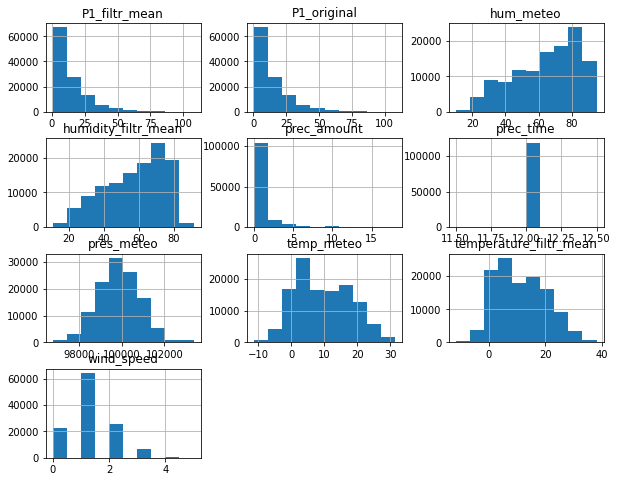

In [10]:
 _ = data.hist()

In [11]:
data_col = ['humidity_filtr_mean', 'temperature_filtr_mean', 'pres_meteo', 'temp_meteo', 'hum_meteo',
               'wind_speed', 'prec_amount', 'prec_time']
target_col = ['P1_filtr_mean']

In [12]:
data_transform = QuantileTransformer(output_distribution='normal')
data[data_col] = data_transform.fit_transform(data[data_col])

In [13]:
target_transform = QuantileTransformer(output_distribution='normal')
data[target_col] = target_transform.fit_transform(data[target_col])

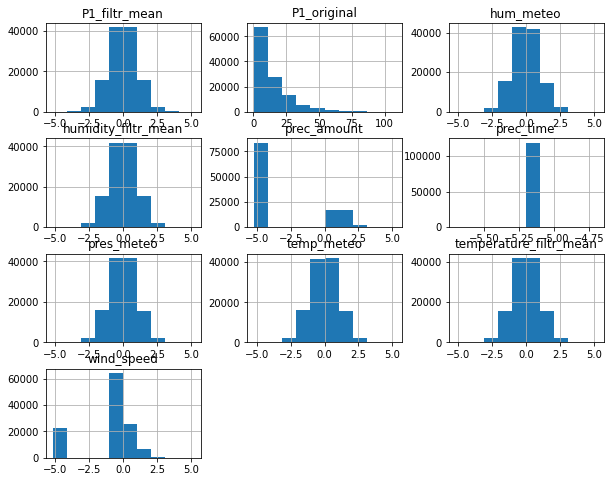

In [14]:
_ = data.hist()

In [15]:
data = add_features(data)
data = data.resample('1H').mean()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9931 entries, 2019-04-01 00:00:00+00:00 to 2020-05-18 18:00:00+00:00
Freq: H
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   P1_filtr_mean           9931 non-null   float64
 1   humidity_filtr_mean     9931 non-null   float64
 2   temperature_filtr_mean  9931 non-null   float64
 3   pres_meteo              9931 non-null   float64
 4   temp_meteo              9931 non-null   float64
 5   hum_meteo               9931 non-null   float64
 6   wind_direction          8153 non-null   float64
 7   wind_speed              9931 non-null   float64
 8   prec_amount             9931 non-null   float64
 9   prec_time               9931 non-null   float64
 10  P1_original             9931 non-null   float64
 11  day_of_week             9931 non-null   int64  
 12  hour                    9931 non-null   int64  
 13  sin_day                 9931 non-null

# Split data on chunks

In [17]:
train_data = data['2019-04-02 00:00:00+00:00':str(data.index[-1] - datetime.timedelta(days=50))]
test_data = data[str(data.index[-1] - datetime.timedelta(days=50)):]

In [18]:
def pp(start, end, n):
    """generation of random datetime indexes"""
    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.DatetimeIndex((10**9*np.random.randint(start_u, end_u, n)).view('M8[ns]'))

In [19]:
def generate_chunks(series, n, start, end, chunk_len, test_len, features):
    chunks = []
    for idx in pp(start, end, n):
        train_part = series[str(idx):str(idx+datetime.timedelta(hours=chunk_len-test_len))]
        test_part = series[str(idx+datetime.timedelta(hours=chunk_len-test_len)):str(idx+datetime.timedelta(hours=chunk_len))]
        chunk = Chunk(train_part, test_part, features)
        chunks.append(chunk)
    return chunks

In [20]:
chunk_len = 48
test_len = 24
train_start_idx = train_data.index[0]
train_end_idx = train_data.index[-1] - datetime.timedelta(hours=chunk_len)
train_num_samples = round(len(train_data)/3.2)
features = ['pres_meteo', 'temp_meteo', 'hum_meteo', 'wind_speed', 'prec_amount',
           'sin_day', 'cos_day', 'sin_hour', 'cos_hour', 'wind_sin', 'wind_cos', 'temp_diff', 'humidity_diff',
           'pressure_diff', 'temp_diff3', 'humidity_diff3',
           'pressure_diff3']
np.random.seed(42)

train_chunks = generate_chunks(train_data, train_num_samples,
                               train_start_idx, train_end_idx,
                               chunk_len, test_len, features)

test_start_idx = test_data.index[0]
test_end_idx = test_data.index[-1] - datetime.timedelta(hours=chunk_len)
test_num_samples = 300

test_chunks = generate_chunks(test_data, test_num_samples,
                              test_start_idx, test_end_idx,
                              chunk_len, test_len,
                              features)

In [21]:
train, train_meta = train_test_split(train_chunks, test_size=0.5, random_state=42)

# Train models

In [22]:
def train_models(model, chunks, num_models):
    models = []
    for i in range(num_models):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = clone(model)
        y = [chunk.get_y(i) for chunk in chunks]
        local_model.fit(X, y)
        models.append(local_model)
    return models

In [23]:
def get_mae(models, chunks, transform):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = models[i]
        prediction = local_model.predict(X)
        prediction = transform.inverse_transform(prediction.reshape(-1, 1))
        y = [chunk.get_y(i, orig=True) for chunk in chunks]
        mae = mean_absolute_error(y, prediction)
        scores.append(mae)
    return scores

In [24]:
def get_mse(models, chunks, transform):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = models[i]
        prediction = local_model.predict(X)
        prediction = transform.inverse_transform(prediction.reshape(-1, 1))
        y = [chunk.get_y(i, orig=True) for chunk in chunks]
        mae = mean_squared_error(y, prediction)
        scores.append(mae)
    return scores

In [25]:
%%time
#mod = RandomForestRegressor(min_samples_leaf=3, random_state=42)
#mod = LinearRegression()
mod = Lasso(alpha=0.005, random_state=42, max_iter=3000)
models = train_models(mod, train, test_len)

CPU times: user 11.9 s, sys: 3.49 s, total: 15.4 s
Wall time: 7.76 s


In [26]:
mae = get_mae(models, test_chunks, target_transform)
mse = get_mse(models, test_chunks, target_transform)

In [27]:
alpha = [0.005, 0.007, 0.008, 0.01]
for i in range(len(alpha)):
    mod = Lasso(alpha=alpha[i], random_state=42)
    models = train_models(mod, train, test_len)
    mae = get_mae(models, test_chunks, target_transform)
    print(alpha[i], np.mean(mae))

0.005 2.9077055984521176
0.007 2.911210794983988
0.008 2.913810814774935
0.01 2.920214119181958


In [28]:
mae, np.mean(mae)

([0.7326635858669226,
  1.2634028749384303,
  1.8092887476886512,
  2.1797799073285415,
  2.510125218918141,
  2.677881142349376,
  2.791066292397491,
  2.959243133707256,
  3.1929565015695704,
  3.309877574732844,
  3.2952305363565886,
  3.219191795884334,
  3.269699711314915,
  3.2649151505871417,
  3.2637601223663935,
  3.2667393041243815,
  3.1969245324446067,
  3.192557082390387,
  3.153440245548018,
  3.279819906629734,
  3.457151701863925,
  3.5377652172030154,
  3.600344222854149,
  3.661314351302186],
 2.920214119181958)

In [29]:
np.sqrt(mse), np.mean(np.sqrt(mse))

(array([1.1367529 , 1.94381627, 3.00502803, 3.48592716, 3.89964996,
        4.15975499, 4.26522135, 4.49816066, 4.88535435, 5.08571112,
        4.93025519, 4.691141  , 4.69489012, 4.74979236, 4.7022435 ,
        4.52690821, 4.3984755 , 4.48190164, 4.55392107, 4.72520714,
        4.86200727, 4.82889198, 4.87608827, 5.07031229]), 4.269058847426863)

# Train meta models

In [30]:
def train_meta_models(meta_model, models, chunks, num_models):
    meta_models = []
    for i in range(num_models):
        X = [chunk.get_meta_X(i, models) for chunk in chunks]
        local_model = clone(meta_model)
        y = [chunk.get_y(i) for chunk in chunks]
        local_model.fit(X, y)
        meta_models.append(local_model)
    return meta_models

In [31]:
def get_meta_mae(models, meta_models, chunks, transform):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_meta_X(i, models) for chunk in chunks]
        local_model = meta_models[i]
        prediction = local_model.predict(X)
        prediction = transform.inverse_transform(prediction.reshape(-1, 1))
        y = [chunk.get_y(i, orig=True) for chunk in chunks]
        mae = mean_absolute_error(y, prediction)
        scores.append(mae)
    return scores

In [32]:
def get_meta_mse(models, meta_models, chunks, transform):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_meta_X(i, models) for chunk in chunks]
        local_model = meta_models[i]
        prediction = local_model.predict(X)
        prediction = transform.inverse_transform(prediction.reshape(-1, 1))
        y = [chunk.get_y(i, orig=True) for chunk in chunks]
        mae = mean_squared_error(y, prediction)
        scores.append(mae)
    return scores

In [33]:
%%time
#meta_model = Lasso(alpha=0.2, random_state=42)
#meta_model = Ridge(alpha=0.6, random_state=42)
meta_model = RandomForestRegressor(min_samples_leaf=3, random_state=42)
meta_models = train_meta_models(meta_model, models, train_meta, test_len)

CPU times: user 29 s, sys: 169 ms, total: 29.2 s
Wall time: 29.6 s


In [34]:
meta_mae = get_meta_mae(models, meta_models, test_chunks, target_transform)
meta_mse = get_meta_mse(models, meta_models, test_chunks, target_transform)

In [35]:
def get_feature_impotances(models):
    importance = models[0].feature_importances_
    for mod in models[1:]:
        local_importance = mod.feature_importances_
        importance += local_importance
    importance = importance / len(models)
    return list(importance)

In [36]:
get_feature_impotances(meta_models)

[0.5471417738999403,
 0.05975911278885007,
 0.03736484486942071,
 0.07438372496029964,
 0.1079730405718654,
 0.028503275002176174,
 0.014445114463947068,
 0.009918413631826222,
 0.01761690852652512,
 0.022776674475920137,
 0.011899630917945318,
 0.04938448408504365,
 0.0025177977259092862,
 0.0023027315811707185,
 0.004773450148528952,
 0.0023917946161220506,
 0.002348570416054238,
 0.004498657318454974]

In [37]:
alpha = [2, 3, 4, 5,]
for i in range(len(alpha)):
    meta_model = RandomForestRegressor(min_samples_leaf=alpha[i], random_state=42)
    meta_models = train_meta_models(meta_model, models, train_meta, test_len)
    meta_mae = get_meta_mae(models, meta_models, test_chunks, target_transform)
    print(alpha[i], np.mean(meta_mae))

2 2.573399146448164
3 2.5664310460682143
4 2.5564324651226507
5 2.5613975141061576


In [38]:
np.mean(meta_mae)

2.5613975141061576

In [39]:
np.mean(np.sqrt(meta_mse))

3.9790781123803267

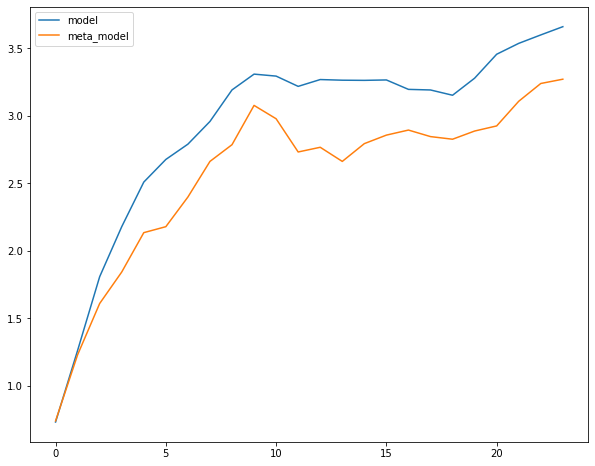

In [40]:
plt.plot(mae, label='model')
plt.plot(meta_mae, label='meta_model')
plt.legend()

In [41]:
mae, np.mean(mae)

([0.7326635858669226,
  1.2634028749384303,
  1.8092887476886512,
  2.1797799073285415,
  2.510125218918141,
  2.677881142349376,
  2.791066292397491,
  2.959243133707256,
  3.1929565015695704,
  3.309877574732844,
  3.2952305363565886,
  3.219191795884334,
  3.269699711314915,
  3.2649151505871417,
  3.2637601223663935,
  3.2667393041243815,
  3.1969245324446067,
  3.192557082390387,
  3.153440245548018,
  3.279819906629734,
  3.457151701863925,
  3.5377652172030154,
  3.600344222854149,
  3.661314351302186],
 2.920214119181958)

In [42]:
meta_mae, np.mean(meta_mae)

([0.7408402785077015,
  1.2311046158092767,
  1.610777889915003,
  1.843970135853956,
  2.135558689903348,
  2.179836383328035,
  2.3994080841129115,
  2.6632821971345204,
  2.7871956372846642,
  3.0781896060657723,
  2.9792512766622306,
  2.7331831950021734,
  2.768014528892098,
  2.6633049290187705,
  2.7950678327958456,
  2.858077540546737,
  2.8955021680651294,
  2.847120624541757,
  2.82769715913502,
  2.888290655101996,
  2.926200774875483,
  3.108805785481163,
  3.2405807445534056,
  3.2722796059607906],
 2.5613975141061576)

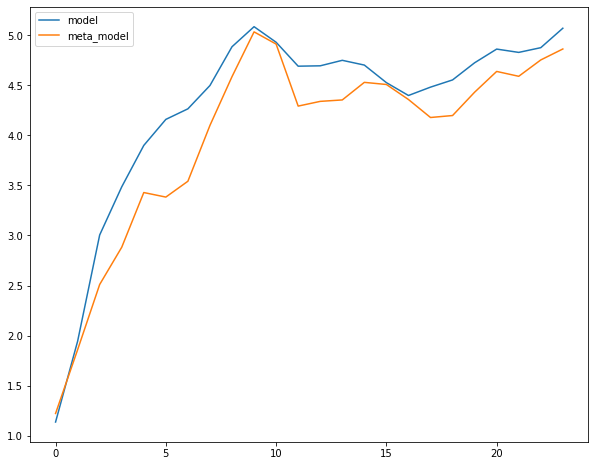

In [43]:
plt.plot(np.sqrt(mse), label='model')
plt.plot(np.sqrt(meta_mse), label='meta_model')
plt.legend()

In [44]:
np.sqrt(mse), np.mean(np.sqrt(mse))

(array([1.1367529 , 1.94381627, 3.00502803, 3.48592716, 3.89964996,
        4.15975499, 4.26522135, 4.49816066, 4.88535435, 5.08571112,
        4.93025519, 4.691141  , 4.69489012, 4.74979236, 4.7022435 ,
        4.52690821, 4.3984755 , 4.48190164, 4.55392107, 4.72520714,
        4.86200727, 4.82889198, 4.87608827, 5.07031229]), 4.269058847426863)

In [45]:
np.sqrt(meta_mse), np.mean(np.sqrt(meta_mse))

(array([1.22223214, 1.85896947, 2.51053125, 2.88256786, 3.42907378,
        3.38374759, 3.54190386, 4.09976086, 4.58663209, 5.03400441,
        4.91209419, 4.29255173, 4.33971085, 4.35406911, 4.52961986,
        4.508367  , 4.35840646, 4.17863843, 4.19820031, 4.43131081,
        4.63871093, 4.59022588, 4.75354661, 4.86299923]), 3.9790781123803267)

In [46]:
def get_predictions(models, meta_models, chunk, transform):
    predictions = []
    for i in range(len(models)):
        X = [chunk.get_meta_X(i, models) ]
        local_model = meta_models[i]
        prediction = local_model.predict(X)
        prediction = transform.inverse_transform(prediction.reshape(-1, 1))[0][0]
        predictions.append(prediction)
    return predictions

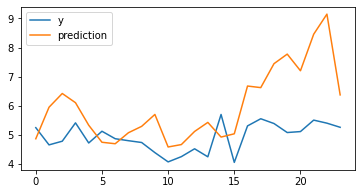

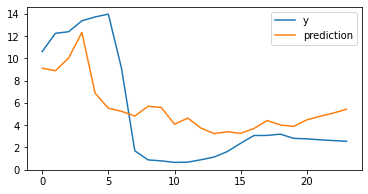

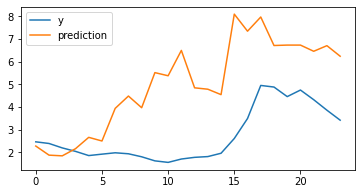

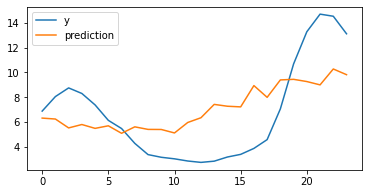

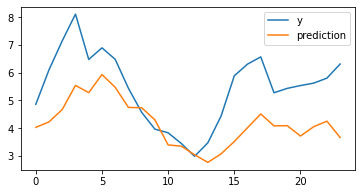

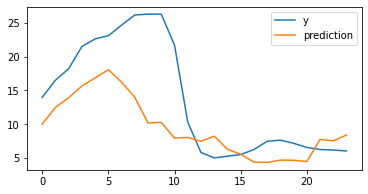

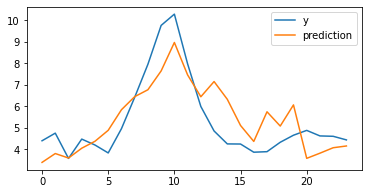

In [47]:
for chunk_num in [1, 34 ,53, 75, 166, 203, 42]:
    plt.figure(figsize=(6, 3))
    plt.plot([test_chunks[chunk_num].get_y(i, orig=True) for i in range(len(meta_models))], label='y')
    plt.plot(get_predictions(models, meta_models, test_chunks[chunk_num], target_transform), label='prediction')
    plt.legend()

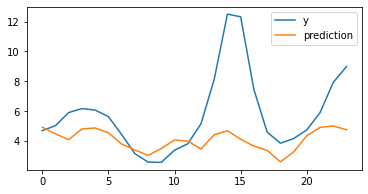

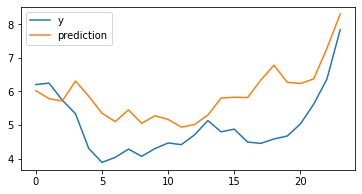

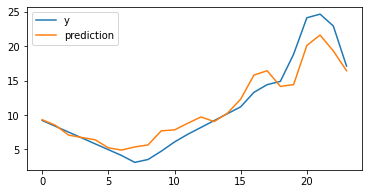

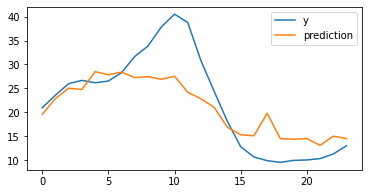

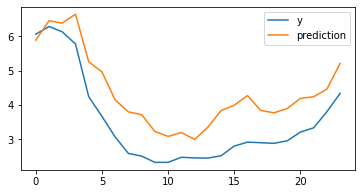

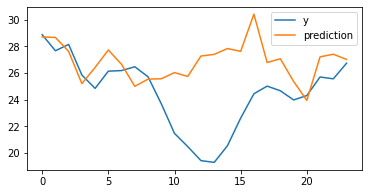

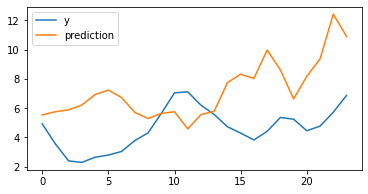

In [48]:
for chunk_num in [1, 34 ,53, 75, 166, 203, 42]:
    plt.figure(figsize=(6, 3))
    plt.plot([train_chunks[chunk_num].get_y(i, orig=True) for i in range(len(meta_models))], label='y')
    plt.plot(get_predictions(models, meta_models, train_chunks[chunk_num], target_transform), label='prediction')
    plt.legend()